In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, ReLU, BatchNormalization, Add, GlobalAveragePooling2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from sklearn.model_selection import train_test_split

In [2]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.9.249.194:8470']


In [ ]:
# loading and splitting dataset into training and testing data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

val_size = 0.1

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=val_size, random_state=42
)

# one hot encoding the integer labels
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(y_test)

# converting numpy arrays of uint8 dtype to tensors
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [ ]:
# performing image augmentations
def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_brightness(image, max_delta=0.2)

    image = tf.image.random_crop(image, size=[27, 27, 3])
    image = tf.image.resize(image, size=[32, 32], method=tf.image.ResizeMethod.LANCZOS3)

    return image, label

augmented_dataset = train_dataset.map(augment_data)
train_dataset = train_dataset.concatenate(augmented_dataset)

In [ ]:
# normalizing the images in our datasets
def normalize_images(image, label):
    image = image/255.0

    return image, label

train_dataset = train_dataset.map(normalize_images)
val_dataset = val_dataset.map(normalize_images)
x_test = x_test/255.0

# shuffling and batching our datasets
batch_size=128

train_dataset = train_dataset.shuffle(buffer_size=90000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [ ]:
# function to build residual blocks. 'pooling' is a boolean value.
def residual_block(x, filters, pooling, reg_strength=0):
    shortcut = x

    if pooling:
        # first conv layer
        x = Conv2D(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_strength))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        # second conv layer
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_strength))(x)
        x = BatchNormalization()(x) # output of the second conv layer

        shortcut = AveragePooling2D((2, 2))(shortcut) # to reduce the height and width of the shortcut

        depth_diff = x.shape[3] - shortcut.shape[3] # the channel depth of shortcut is smaller than that of x
        depth_padding = int(depth_diff) # zero padding is added at the end of the channel depth
        padded_shortcut = tf.pad(shortcut, [[0, 0], [0, 0], [0, 0], [0, depth_padding]], mode="CONSTANT", constant_values=0)

        x = Add()([x, padded_shortcut])
        x = ReLU()(x)

        return x

    else:
        # first conv layer
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_strength))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        # second conv layer
        x = Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(reg_strength))(x)
        x = BatchNormalization()(x)

        x = Add()([x, shortcut])
        x = ReLU()(x)

        return x

In [ ]:
def build_model(lr, exp_decay, decay_rate, decay_steps):
    inputs = keras.Input(shape=(32, 32, 3))

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.1)(x)

    # three residual blocks, 6x128 layers
    x = residual_block(x, 128, False, reg_strength=0.0001)
    x = Dropout(0.1)(x)
    x = residual_block(x, 128, False, reg_strength=0.0001)
    x = Dropout(0.1)(x)
    x = residual_block(x, 128, False, reg_strength=0.0001)
    x = Dropout(0.1)(x)

    # three residual blocks, 6x256 layers
    x = residual_block(x, 256, True, reg_strength=0.0001)
    x = Dropout(0.1)(x)
    x = residual_block(x, 256, False, reg_strength=0.0001)
    x = Dropout(0.1)(x)
    x = residual_block(x, 256, False, reg_strength=0.0001)
    x = Dropout(0.1)(x)

    # three residual blocks, 6x512 layers
    x = residual_block(x, 512, True, reg_strength=0.0001)
    x = Dropout(0.1)(x)
    x = residual_block(x, 512, False, reg_strength=0.0001)
    x = Dropout(0.1)(x)
    x = residual_block(x, 512, False, reg_strength=0.0001)
    x = Dropout(0.1)(x)

    x = GlobalAveragePooling2D()(x)

    outputs = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

    model = keras.Model(inputs, outputs)

    lr_decay = optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                     decay_steps=decay_steps,
                                                     decay_rate=decay_rate,
                                                     staircase=True)

    if exp_decay:
        optimizer = optimizers.Adam(lr_decay)
    else:
        optimizer = optimizers.Adam(lr)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
checkpoint_callback = ModelCheckpoint(filepath='best_model_weights.h5',
                                      monitor='val_loss',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=0)

In [ ]:
# training the model
with tpu_strategy.scope():
    model = build_model(lr=0.001, exp_decay=True, decay_rate=0.4, decay_steps=3520)

history= model.fit(train_dataset, epochs=40, validation_data=val_dataset, verbose=2, callbacks=[checkpoint_callback])

Epoch 1/40
704/704 - 52s - loss: 2.2646 - accuracy: 0.5260 - val_loss: 2.4712 - val_accuracy: 0.5362 - 52s/epoch - 74ms/step
Epoch 2/40
704/704 - 35s - loss: 1.3519 - accuracy: 0.7112 - val_loss: 1.4406 - val_accuracy: 0.6584 - 35s/epoch - 50ms/step
Epoch 3/40
704/704 - 32s - loss: 1.0882 - accuracy: 0.7623 - val_loss: 1.6336 - val_accuracy: 0.6340 - 32s/epoch - 45ms/step
Epoch 4/40
704/704 - 34s - loss: 0.9926 - accuracy: 0.7845 - val_loss: 1.2501 - val_accuracy: 0.7054 - 34s/epoch - 48ms/step
Epoch 5/40
704/704 - 33s - loss: 0.9426 - accuracy: 0.8039 - val_loss: 1.6797 - val_accuracy: 0.6096 - 33s/epoch - 47ms/step
Epoch 6/40
704/704 - 35s - loss: 0.7198 - accuracy: 0.8629 - val_loss: 0.8744 - val_accuracy: 0.8070 - 35s/epoch - 49ms/step
Epoch 7/40
704/704 - 33s - loss: 0.6574 - accuracy: 0.8726 - val_loss: 0.8377 - val_accuracy: 0.8070 - 33s/epoch - 48ms/step
Epoch 8/40
704/704 - 34s - loss: 0.6215 - accuracy: 0.8826 - val_loss: 0.6876 - val_accuracy: 0.8612 - 34s/epoch - 49ms/step


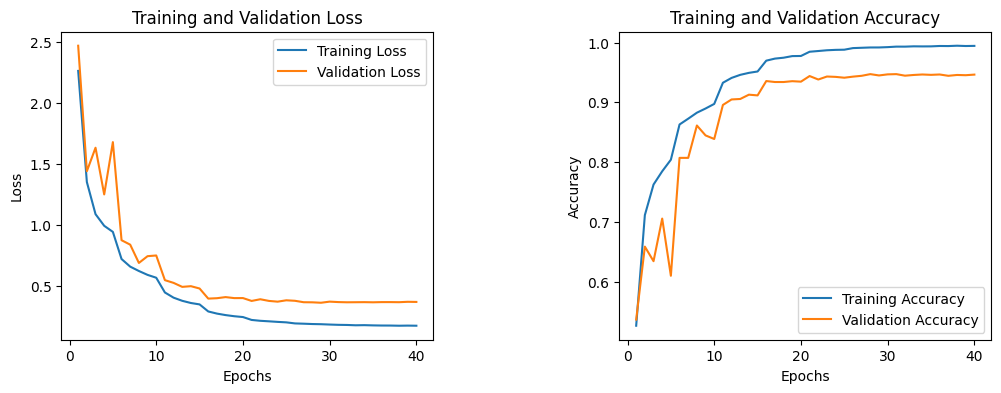

In [ ]:
# plotting the losses and accuracies
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epochs = list(range(1, len(training_loss) + 1))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(epochs, training_loss, label='Training Loss')
axs[0].plot(epochs, validation_loss, label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, training_acc, label='Training Accuracy')
axs[1].plot(epochs, validation_acc, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.subplots_adjust(wspace=0.5)

plt.show()

In [ ]:
# evaluating the model on test data
model.load_weights('best_model_weights.h5')
model.evaluate(x_test, y_test, verbose=2)

313/313 - 6s - loss: 0.3796 - accuracy: 0.9447 - 6s/epoch - 19ms/step


[0.3795933425426483, 0.9447000026702881]